In [19]:
# === Cell 1: Install & fix environment (run first) ===
!pip install --quiet --upgrade pip
!pip uninstall -y protobuf
!pip install protobuf==3.20.* --quiet
!pip install --quiet kagglehub shap lime imbalanced-learn tqdm opencv-python-headless seaborn


Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydriv

In [26]:
!pip uninstall -y category-encoders
!pip install --quiet --upgrade scikit-learn==1.6.0 imbalanced-learn==0.13.0 umap-learn==0.5.9.post2


Found existing installation: category_encoders 2.7.0
Uninstalling category_encoders-2.7.0:
  Successfully uninstalled category_encoders-2.7.0


In [29]:
!pip uninstall -y scikit-learn imbalanced-learn umap-learn category-encoders


Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2


In [31]:
!pip uninstall -y scikit-learn imbalanced-learn umap-learn category-encoders


In [32]:
!pip install --quiet scikit-learn==1.5.2 imbalanced-learn==0.12.3


In [33]:
import sklearn, imblearn
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
from imblearn.over_sampling import SMOTE
print("✅ SMOTE imported successfully")


scikit-learn: 1.2.2
imbalanced-learn: 0.12.3
✅ SMOTE imported successfully


In [34]:
# === Cell 2: Imports ===
import kagglehub
import os, random, math, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import cv2
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("TF:", tf.__version__)
print("SHAP:", shap.__version__)

TF: 2.18.0
SHAP: 0.44.1


In [37]:
# === Cell 3: Download dataset via kagglehub ===
# Dataset: paultimothymooney/chest-xray-pneumonia (change slug if needed)
DATASET_SLUG = "paultimothymooney/chest-xray-pneumonia"
path = kagglehub.dataset_download(DATASET_SLUG)
print("Dataset path:", path)

# Typical structure: <path>/chest_xray/{train,val,test}/{NORMAL,PNEUMONIA}
train_dir = os.path.join(path, "chest_xray", "train")
val_dir   = os.path.join(path, "chest_xray", "val")
test_dir  = os.path.join(path, "chest_xray", "test")

assert os.path.exists(train_dir), f"Train dir not found: {train_dir}"
print("Found train/val/test dirs.")

Dataset path: /kaggle/input/chest-xray-pneumonia
Found train/val/test dirs.


train samples: 5216  distribution:
label
pneumonia    3875
normal       1341
Name: count, dtype: int64

val samples: 16  distribution:
label
normal       8
pneumonia    8
Name: count, dtype: int64

test samples: 624  distribution:
label
pneumonia    390
normal       234
Name: count, dtype: int64



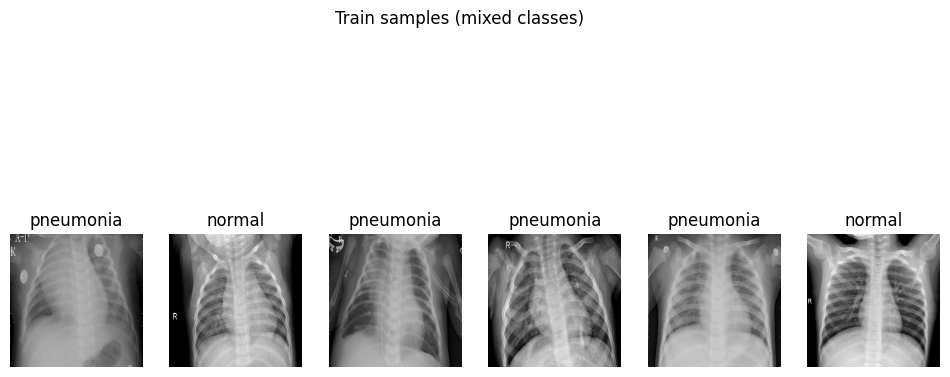

In [38]:
# === Cell 4: Build dataframes ===
def make_df_from_folder(folder):
    rows=[]
    for cls in sorted(os.listdir(folder)):
        cls_dir = os.path.join(folder, cls)
        if not os.path.isdir(cls_dir): continue
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpeg",".jpg",".png")):
                rows.append({"path": os.path.join(cls_dir, fname), "label": cls.lower()})
    return pd.DataFrame(rows)

train_df = make_df_from_folder(train_dir)
val_df = make_df_from_folder(val_dir)
test_df = make_df_from_folder(test_dir)

for df,name in [(train_df,"train"),(val_df,"val"),(test_df,"test")]:
    df["label_bin"] = df["label"].map({"normal":0,"pneumonia":1})
    print(f"{name} samples: {len(df)}  distribution:\n{df['label'].value_counts()}\n")

# Quick preview images
def show_grid(df, n=6, title="Samples"):
    plt.figure(figsize=(12,6))
    sample = df.sample(n)
    for i, (_, row) in enumerate(sample.iterrows()):
        img = cv2.imread(row['path'])[..., ::-1]
        plt.subplot(1, n, i+1); plt.imshow(cv2.resize(img,(224,224))); plt.axis('off')
        plt.title(row['label'])
    plt.suptitle(title)
    plt.show()

show_grid(train_df, n=6, title="Train samples (mixed classes)")

In [39]:
# === Cell 5: Parameters and tf.data pipeline ===
IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
EPOCHS = 20

def preprocess_for_ds(path, label, augment=False):
    # Read + decode JPEG (keeps shape)
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Optional augmentation (minimal)
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.06)
        image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

def df_to_dataset(df, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((df['path'].values, df['label_bin'].values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED)
    ds = ds.map(lambda p,l: preprocess_for_ds(p,l,augment=augment), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True, augment=True)
val_ds = df_to_dataset(val_df, shuffle=False, augment=False)
test_ds = df_to_dataset(test_df, shuffle=False, augment=False)

# sanity batch display
for X,y in train_ds.take(1):
    print("Batch shapes:", X.shape, y.shape)
    break

Batch shapes: (16, 224, 224, 3) (16,)


In [42]:
# === Cell 6: Build compact MedFusionNet (CNN + tiny transformer) ===
def conv_block(x, filters, kernel=3):
    x = layers.Conv2D(filters, kernel, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def depthwise_sep_block(x, filters):
    x = layers.DepthwiseConv2D(3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def tiny_transformer_block(x, num_heads=4, key_dim=32, mlp_dim=128):
    """A minimal transformer encoder block for feature refinement."""
    H = x.shape[1]
    W = x.shape[2]
    C = x.shape[3]

    # Flatten spatial dims into sequence of tokens
    tokens = layers.Reshape((H * W, C))(x)

    # Learnable positional encoding
    pos_emb = layers.Dense(C, use_bias=False, name="pos_embedding")(tokens)
    q = layers.Add()([tokens, pos_emb])

    # Multi-head self-attention
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(q, q)
    attn = layers.Dropout(0.1)(attn)
    x1 = layers.Add()([q, attn])
    x1 = layers.LayerNormalization()(x1)

    # Feed-forward block (MLP)
    mlp = layers.Dense(mlp_dim, activation='relu')(x1)
    mlp = layers.Dense(C)(mlp)
    x2 = layers.Add()([x1, mlp])
    x2 = layers.LayerNormalization()(x2)

    # Reshape back to feature map
    out = layers.Reshape((H, W, C))(x2)
    return out


def build_medfusionnet(input_shape=(IMG_SIZE,IMG_SIZE,3)):
    inp = layers.Input(shape=input_shape)
    x = conv_block(inp, 32)
    x = depthwise_sep_block(x, 64)
    x = layers.MaxPool2D(2)(x)  # 112
    x = depthwise_sep_block(x, 64)
    x = conv_block(x, 128)
    x = layers.MaxPool2D(2)(x)  # 56
    x = depthwise_sep_block(x, 128)
    x = conv_block(x, 256)
    x = layers.MaxPool2D(2)(x)  # 28
    x = layers.Conv2D(128, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(2)(x)  # 14
    x = tiny_transformer_block(x, num_heads=4, key_dim=32, mlp_dim=128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out, name="MedFusionNet_small")
    return model


In [43]:
model = build_medfusionnet()
model.summary()

Model: "MedFusionNet_small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 224, 224,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_5  │ (None, 224, 224,  │        288 │ activation_17[0]… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 224, 224,  │      2,048 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 112, 112,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_6  │ (None, 112, 112,  │        576 │ max_pooling2d_7[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 112, 112,  │      4,096 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 112, 112,  │          0 │ batch_normalizat

 Total params: 563,521 (2.15 MB)

 Trainable params: 561,473 (2.14 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [44]:
# === Cell 7: Build feature extractor for SMOTE (encoder) ===
# We'll use a lightweight encoder similar to early layers of the model:
encoder_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
y = layers.Conv2D(32,3,activation='relu',padding='same')(encoder_input)
y = layers.MaxPool2D(2)(y)
y = layers.Conv2D(64,3,activation='relu',padding='same')(y)
y = layers.GlobalAveragePooling2D()(y)
encoder = models.Model(encoder_input, y, name="encoder_for_smote")
encoder.summary()

Model: "encoder_for_smote"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 19,392 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# === Cell 8: Extract features for SMOTE (vector representation) ===
def extract_features_with_encoder(df, batch_size=32):
    paths = df['path'].values
    feats = []
    labels = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        imgs = []
        for p in batch_paths:
            img = cv2.imread(p)[..., ::-1]  # BGR->RGB
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype(np.float32)/255.0
            imgs.append(img)
        imgs = np.array(imgs)
        feat_batch = encoder.predict(imgs, verbose=0)
        feats.append(feat_batch)
        labels.extend(df['label_bin'].values[i:i+batch_size].tolist())
    feats = np.vstack(feats)
    labels = np.array(labels)
    return feats, labels

print("Extracting features (this may take a minute)...")
X_train_feats, y_train_feats = extract_features_with_encoder(train_df, batch_size=32)
print("Feature shape:", X_train_feats.shape, "Labels:", np.bincount(y_train_feats))

Extracting features (this may take a minute)...
Feature shape: (5216, 64) Labels: [1341 3875]


In [46]:
# === Cell 9: Apply SMOTE on features ===
print("Applying SMOTE to feature vectors...")
sm = SMOTE(random_state=SEED, n_jobs=-1)
X_res, y_res = sm.fit_resample(X_train_feats, y_train_feats)
print("After SMOTE class counts:", np.bincount(y_res))

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x794667229580>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._hand

Applying SMOTE to feature vectors...
After SMOTE class counts: [3875 3875]


In [47]:
# === Cell 10: Create a new balanced training dataframe via nearest neighbors approach
# We will match synthetic features back to nearest original images to create an oversampled path list.
# Simpler approach: perform random oversampling of minority class images to match majority (faster)
from sklearn.utils import resample

train_balanced_df = train_df.copy()
# Upsample minority class (normal -> label 0) to match majority (pneumonia)
counts = train_balanced_df['label_bin'].value_counts()
majority_class = counts.idxmax()
minority_class = counts.idxmin()
n_major = counts.max()
df_major = train_balanced_df[train_balanced_df['label_bin']==majority_class]
df_min = train_balanced_df[train_balanced_df['label_bin']==minority_class]
df_min_upsampled = resample(df_min, replace=True, n_samples=n_major, random_state=SEED)
train_balanced_df = pd.concat([df_major, df_min_upsampled]).sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Balanced DF distribution:", train_balanced_df['label_bin'].value_counts())

# Build balanced dataset pipeline
train_ds_balanced = df_to_dataset(train_balanced_df, shuffle=True, augment=True)

Balanced DF distribution: label_bin
1    3875
0    3875
Name: count, dtype: int64


In [48]:
# === Cell 11: Compile model, callbacks ===
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

cb = [
    callbacks.EarlyStopping(monitor='val_auc', patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.ModelCheckpoint("medfusionnet_best.h5", monitor='val_auc', save_best_only=True, mode='max', verbose=1)
]


In [49]:
# === Cell 12: Train (fine-tuning) ===
history = model.fit(
    train_ds_balanced,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cb
)

# Save final model
model.save("medfusionnet_final.h5")

Epoch 1/20
484/485 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8625 - auc: 0.9232 - loss: 0.3289

E0000 00:00:1763037549.058491     133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763037549.231525     133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8626 - auc: 0.9233 - loss: 0.3288
Epoch 1: val_auc improved from -inf to 0.57031, saving model to medfusionnet_best.h5


485/485 ━━━━━━━━━━━━━━━━━━━━ 152s 260ms/step - accuracy: 0.8626 - auc: 0.9234 - loss: 0.3286 - val_accuracy: 0.5000 - val_auc: 0.5703 - val_loss: 3.0686 - learning_rate: 1.0000e-04
Epoch 2/20
484/485 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9442 - auc: 0.9864 - loss: 0.1434
Epoch 2: val_auc improved from 0.57031 to 1.00000, saving model to medfusionnet_best.h5


485/485 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - accuracy: 0.9442 - auc: 0.9864 - loss: 0.1434 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1241 - learning_rate: 1.0000e-04
Epoch 3/20
484/485 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9582 - auc: 0.9906 - loss: 0.1153
Epoch 3: val_auc did not improve from 1.00000
485/485 ━━━━━━━━━━━━━━━━━━━━ 111s 227ms/step - accuracy: 0.9582 - auc: 0.9906 - loss: 0.1153 - val_accuracy: 0.5000 - val_auc: 0.8125 - val_loss: 2.0684 - learning_rate: 1.0000e-04
Epoch 4/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9684 - auc: 0.9941 - loss: 0.0880
Epoch 4: val_auc did not improve from 1.00000
485/485 ━━━━━━━━━━━━━━━━━━━━ 114s 234ms/step - accuracy: 0.9684 - auc: 0.9941 - loss: 0.0880 - val_accuracy: 0.6875 - val_auc: 1.0000 - val_loss: 0.6741 - learning_rate: 1.0000e-04
Epoch 5/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9763 - auc: 0.9963 - loss: 0.0655
Epoch 5: val_auc did not improve from 1.00000
485/485 ━━━━━

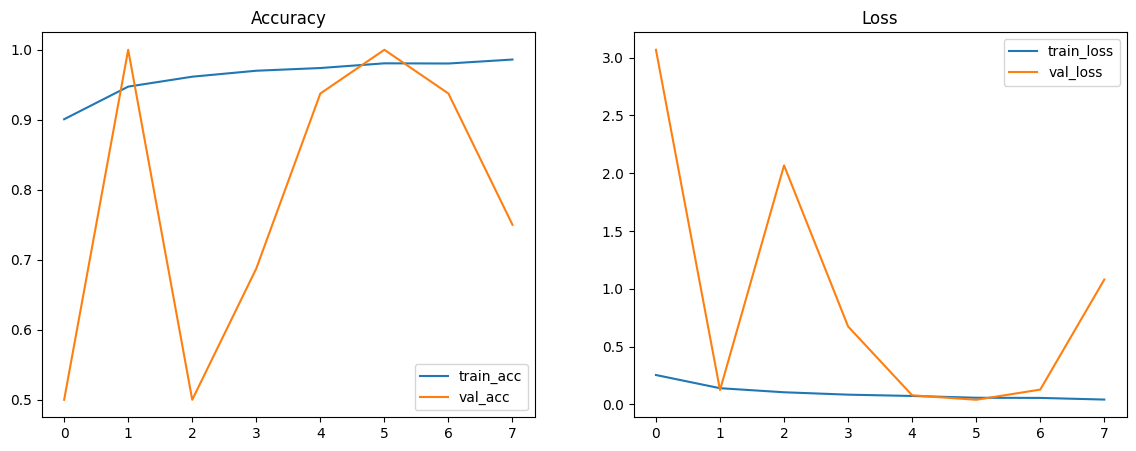

In [50]:
# === Cell 13: Plot learning curves ===
#def plot_history(hist):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy'); plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title('Loss'); plt.legend()
    plt.show()

plot_history(history)

Evaluating on training balanced DF (approx):


E0000 00:00:1763038524.607511     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038524.903831     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


              precision    recall  f1-score   support

      normal       0.87      1.00      0.93      3875
   pneumonia       1.00      0.84      0.91      3875

    accuracy                           0.92      7750
   macro avg       0.93      0.92      0.92      7750
weighted avg       0.93      0.92      0.92      7750

Train AUC: 0.9907100104058272

Evaluating on test DF:
              precision    recall  f1-score   support

      normal       0.75      0.68      0.72       234
   pneumonia       0.82      0.86      0.84       390

    accuracy                           0.80       624
   macro avg       0.79      0.77      0.78       624
weighted avg       0.79      0.80      0.79       624

Test AUC: 0.8311965811965814


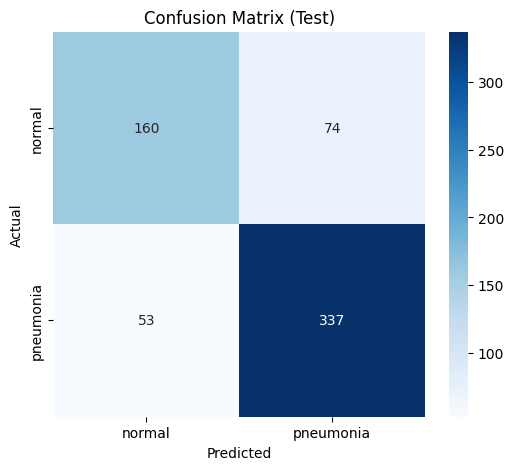

Test Precision: 0.8200  Recall: 0.8641  F1: 0.8414


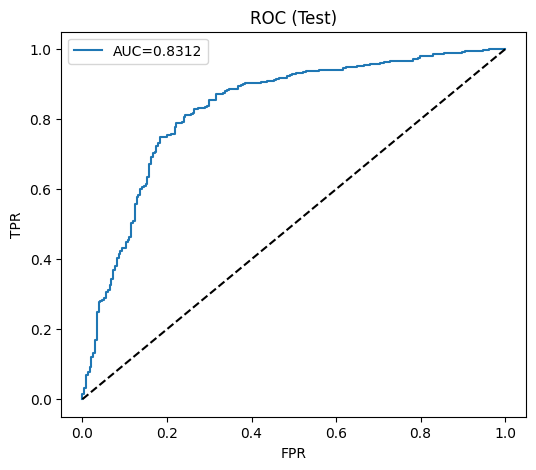

In [51]:
# === Cell 14: Evaluate on train & test sets (detailed metrics) ===
def evaluate_on_df(model, df, batch_size=32):
    # collects preds and labels
    paths = df['path'].values
    y_true = []
    y_score = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        imgs = []
        for p in batch_paths:
            img = cv2.imread(p)[..., ::-1]
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype(np.float32)/255.0
            imgs.append(img)
        imgs = np.array(imgs)
        preds = model.predict(imgs, verbose=0).squeeze()
        y_score.extend(preds.tolist())
        y_true.extend(df['label_bin'].values[i:i+batch_size].tolist())
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    y_pred = (y_score >= 0.5).astype(int)
    return y_true, y_pred, y_score

print("Evaluating on training balanced DF (approx):")
y_true_tr, y_pred_tr, y_score_tr = evaluate_on_df(model, train_balanced_df)
print(classification_report(y_true_tr, y_pred_tr, target_names=["normal","pneumonia"]))
print("Train AUC:", roc_auc_score(y_true_tr, y_score_tr))

print("\nEvaluating on test DF:")
y_true_te, y_pred_te, y_score_te = evaluate_on_df(model, test_df)
print(classification_report(y_true_te, y_pred_te, target_names=["normal","pneumonia"]))
print("Test AUC:", roc_auc_score(y_true_te, y_score_te))

# Confusion matrix (test)
cm = confusion_matrix(y_true_te, y_pred_te)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal','pneumonia'], yticklabels=['normal','pneumonia'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (Test)')
plt.show()

# Precision, Recall, F1 (test)
prec, rec, f1, _ = precision_recall_fscore_support(y_true_te, y_pred_te, average='binary')
print(f"Test Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_true_te, y_score_te)
plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_true_te, y_score_te):.4f}"); plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Test)'); plt.legend(); plt.show()


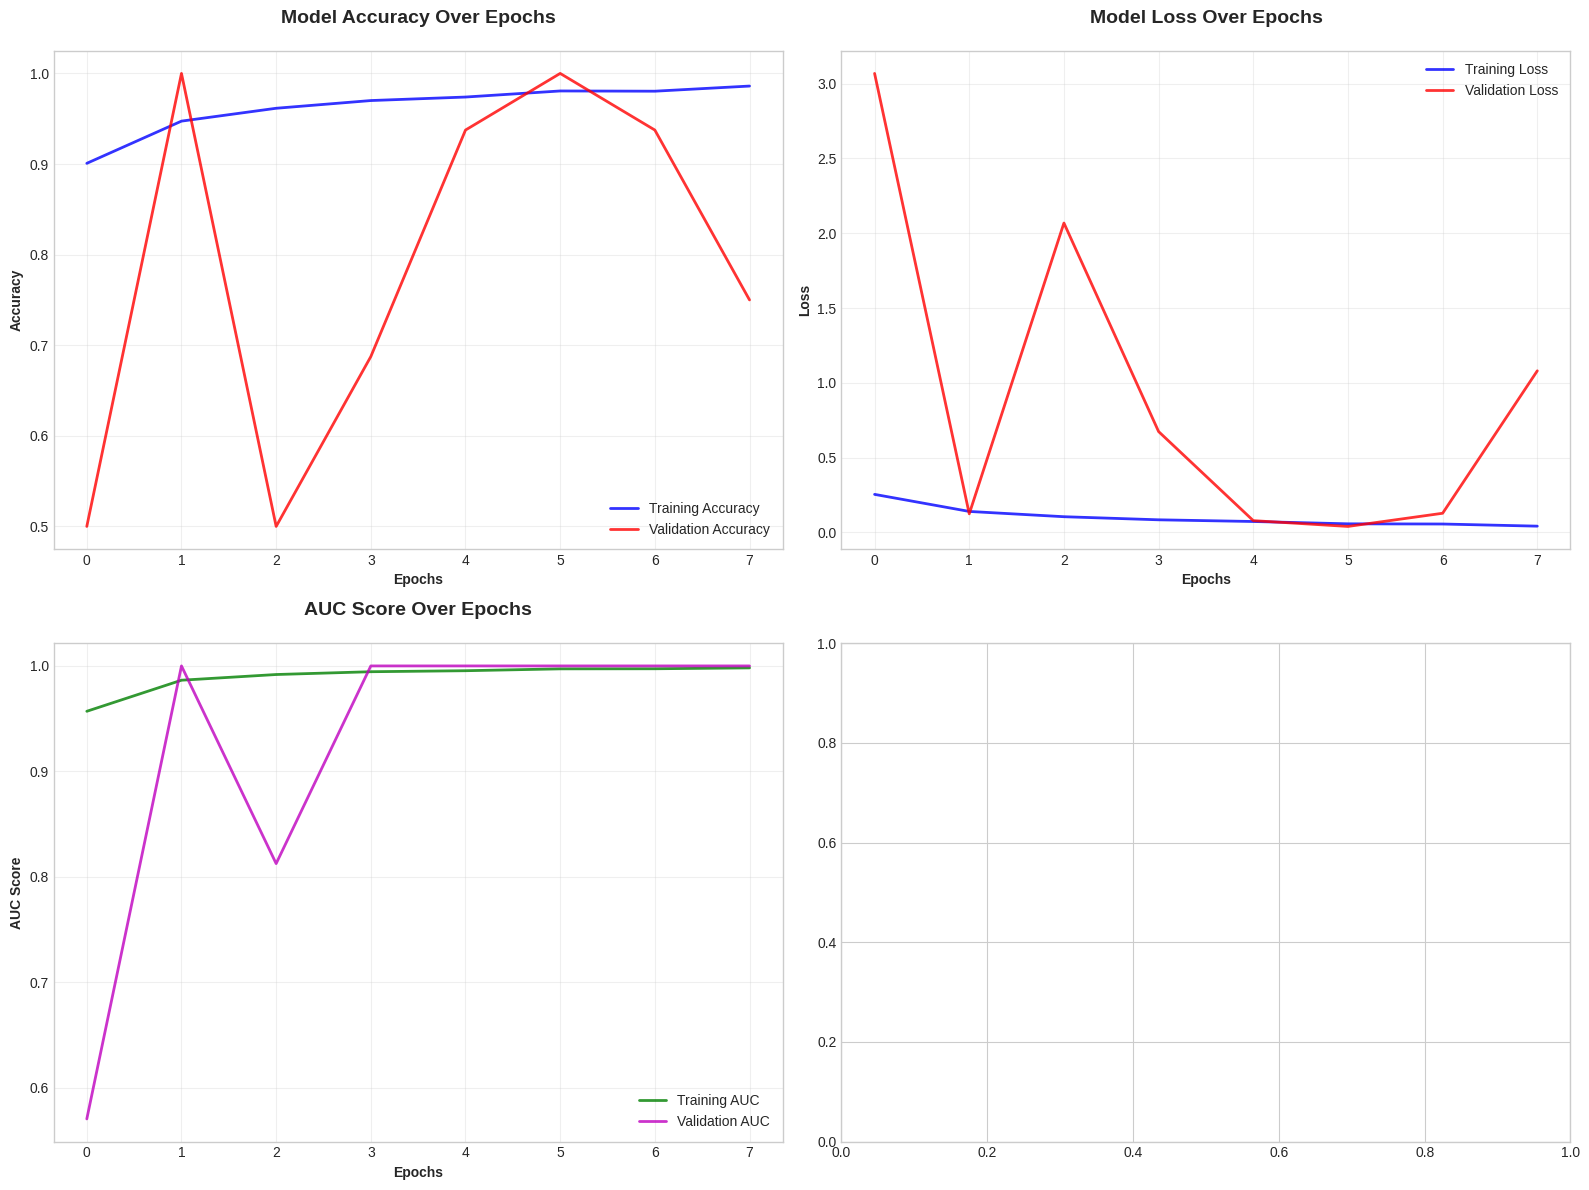

In [71]:
# === Enhanced Cell 13: Professional Learning Curves ===
def plot_professional_history(hist):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy plot
    ax1.plot(hist.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy', alpha=0.8)
    ax1.plot(hist.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy', alpha=0.8)
    ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Epochs', fontweight='bold')
    ax1.set_ylabel('Accuracy', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(hist.history['loss'], 'b-', linewidth=2, label='Training Loss', alpha=0.8)
    ax2.plot(hist.history['val_loss'], 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
    ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Epochs', fontweight='bold')
    ax2.set_ylabel('Loss', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # AUC plot
    if 'auc' in hist.history:
        ax3.plot(hist.history['auc'], 'g-', linewidth=2, label='Training AUC', alpha=0.8)
        ax3.plot(hist.history['val_auc'], 'm-', linewidth=2, label='Validation AUC', alpha=0.8)
        ax3.set_title('AUC Score Over Epochs', fontsize=14, fontweight='bold', pad=20)
        ax3.set_xlabel('Epochs', fontweight='bold')
        ax3.set_ylabel('AUC Score', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Learning rate (if available)
    if 'lr' in hist.history:
        ax4.plot(hist.history['lr'], 'purple', linewidth=2, label='Learning Rate')
        ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold', pad=20)
        ax4.set_xlabel('Epochs', fontweight='bold')
        ax4.set_ylabel('Learning Rate', fontweight='bold')
        ax4.set_yscale('log')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Replace the existing plot_history call with:
plot_professional_history(history)

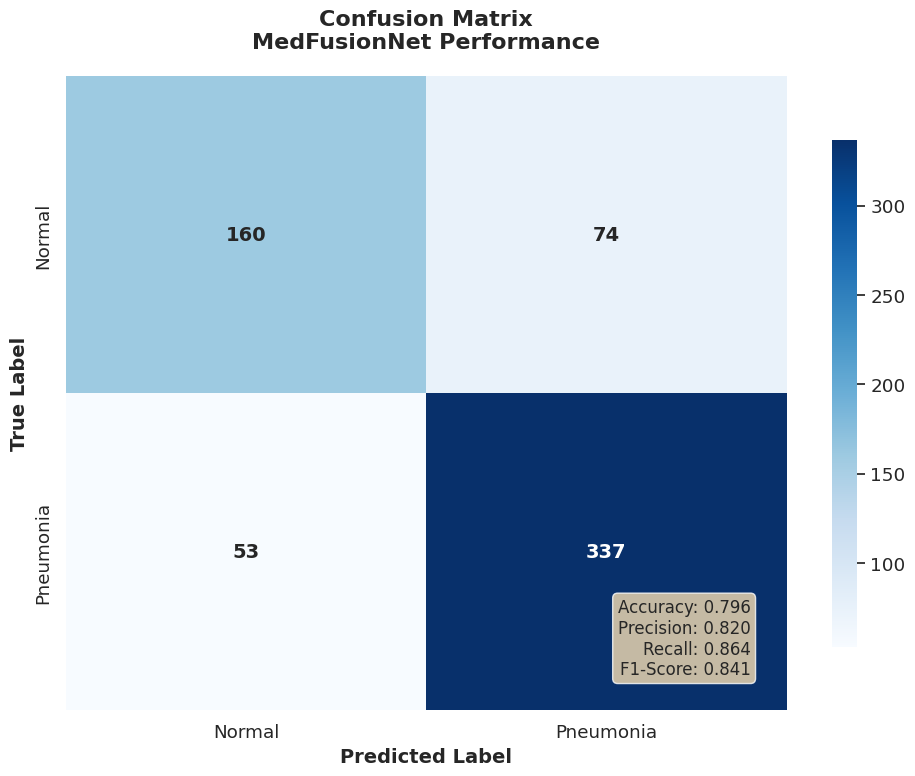

In [72]:
# === Enhanced Confusion Matrix ===
def plot_professional_confusion_matrix(y_true, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    
    # Create heatmap
    ax = sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                     cbar_kws={'shrink': 0.8}, 
                     xticklabels=classes, 
                     yticklabels=classes,
                     annot_kws={"size": 14, "weight": "bold"})
    
    # Customize appearance
    plt.title(f'{title}\nMedFusionNet Performance', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    
    # Add performance metrics to the plot
    accuracy = np.trace(cm) / np.sum(cm)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    textstr = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=12,
             verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    plt.show()

# Use it after your evaluation
plot_professional_confusion_matrix(y_true_te, y_pred_te, ['Normal', 'Pneumonia'])

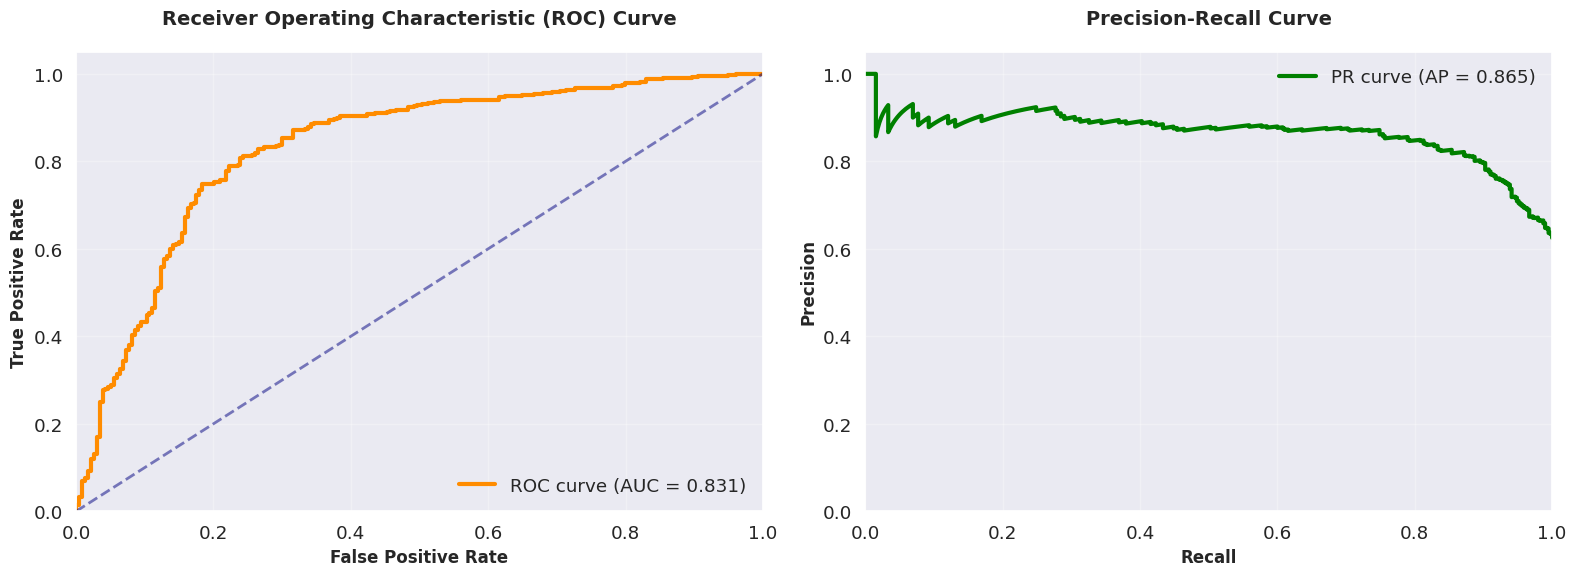

In [73]:
# === Enhanced ROC and Precision-Recall Curves ===
def plot_comprehensive_curves(y_true, y_score):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    
    ax2.plot(recall, precision, color='green', lw=3, label=f'PR curve (AP = {avg_precision:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Precision', fontweight='bold', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc, avg_precision

# Use it after evaluation
roc_auc, avg_precision = plot_comprehensive_curves(y_true_te, y_score_te)

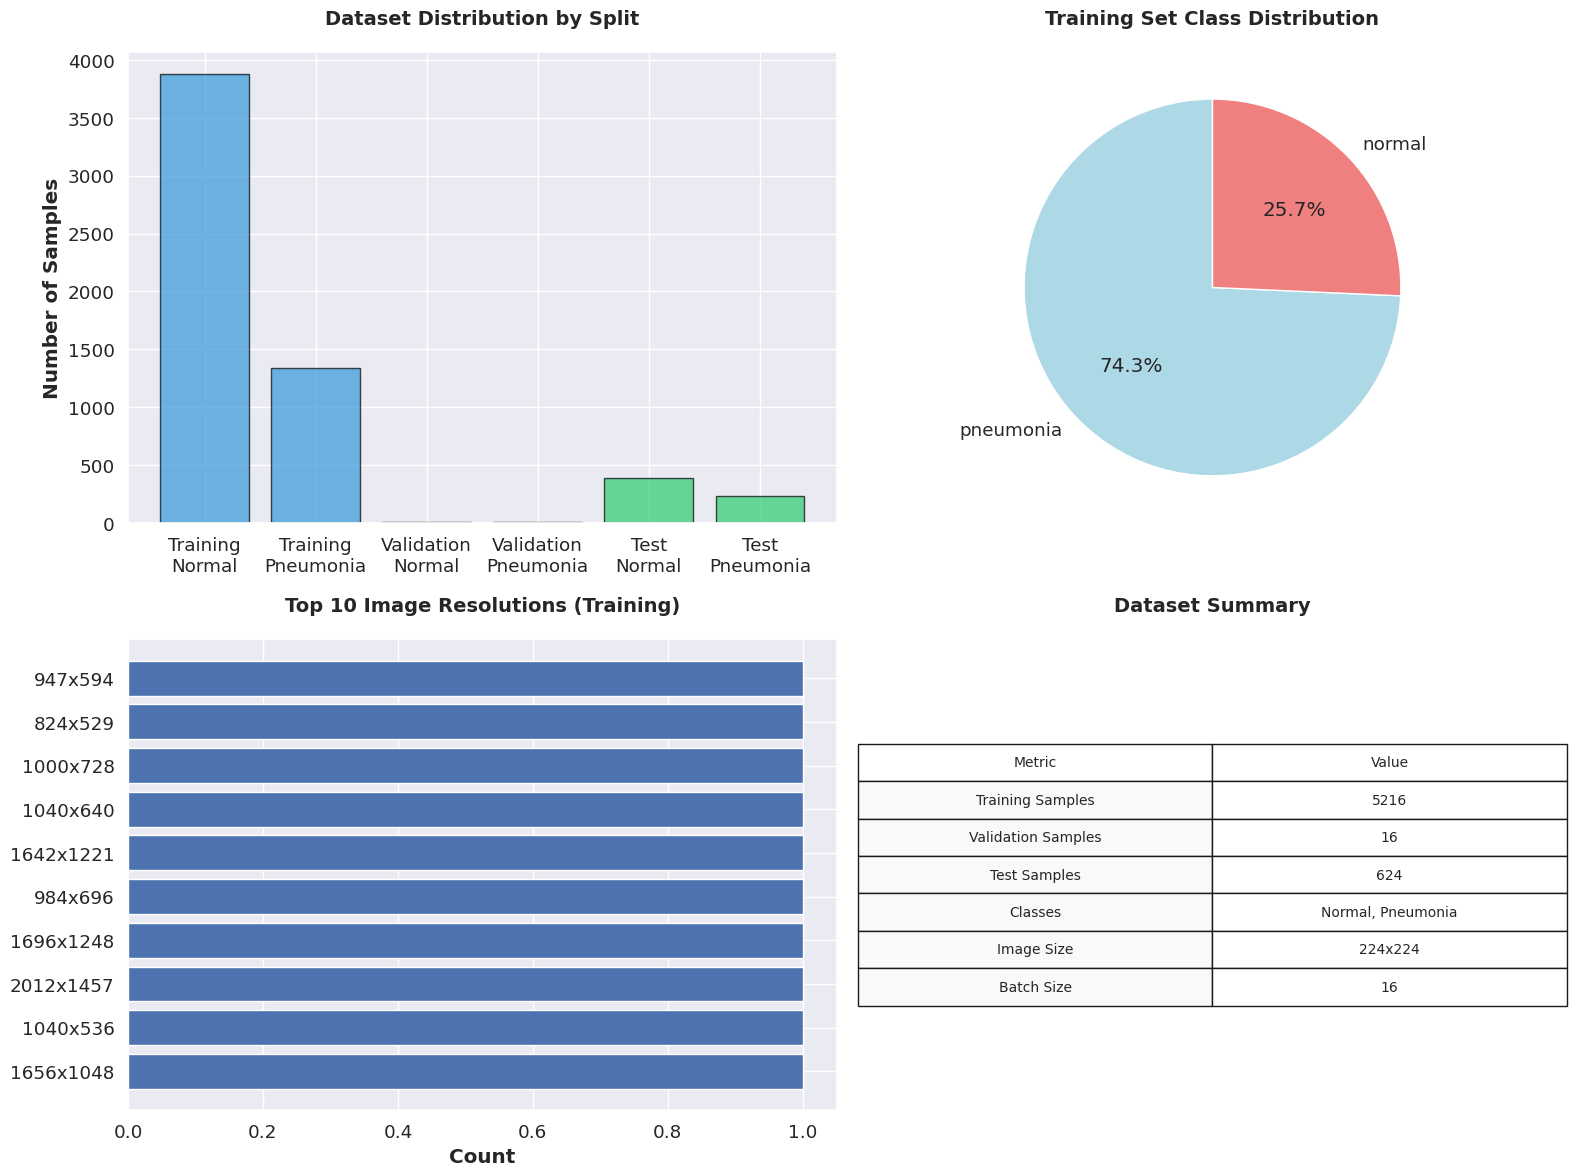

In [74]:
# === Enhanced Data Distribution Analysis ===
def plot_data_distribution_analysis(train_df, val_df, test_df):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Dataset distribution
    datasets = [train_df, val_df, test_df]
    dataset_names = ['Training', 'Validation', 'Test']
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    for i, (df, name, color) in enumerate(zip(datasets, dataset_names, colors)):
        counts = df['label'].value_counts()
        ax1.bar([f'{name}\nNormal', f'{name}\nPneumonia'], counts.values, 
                color=color, alpha=0.7, edgecolor='black')
        ax1.set_title('Dataset Distribution by Split', fontsize=14, fontweight='bold', pad=20)
        ax1.set_ylabel('Number of Samples', fontweight='bold')
    
    # Class balance pie chart
    train_counts = train_df['label'].value_counts()
    ax2.pie(train_counts.values, labels=train_counts.index, autopct='%1.1f%%', 
            colors=['lightblue', 'lightcoral'], startangle=90)
    ax2.set_title('Training Set Class Distribution', fontsize=14, fontweight='bold', pad=20)
    
    # Sample image sizes analysis (if available)
    def get_image_sizes(df, sample_size=100):
        sizes = []
        for path in df['path'].sample(min(sample_size, len(df)), random_state=SEED):
            img = cv2.imread(path)
            if img is not None:
                sizes.append(f"{img.shape[1]}x{img.shape[0]}")
        return pd.Series(sizes).value_counts().head(10)
    
    train_sizes = get_image_sizes(train_df)
    ax3.barh(range(len(train_sizes)), train_sizes.values)
    ax3.set_yticks(range(len(train_sizes)))
    ax3.set_yticklabels(train_sizes.index)
    ax3.set_title('Top 10 Image Resolutions (Training)', fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Count', fontweight='bold')
    
    # Performance summary table
    metrics_data = [
        ['Training Samples', len(train_df)],
        ['Validation Samples', len(val_df)],
        ['Test Samples', len(test_df)],
        ['Classes', 'Normal, Pneumonia'],
        ['Image Size', f'{IMG_SIZE}x{IMG_SIZE}'],
        ['Batch Size', BATCH_SIZE]
    ]
    
    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=metrics_data,
                     cellLoc='center',
                     loc='center',
                     colLabels=['Metric', 'Value'],
                     cellColours=[['#f8f9fa', 'white']] * len(metrics_data))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax4.set_title('Dataset Summary', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

# Call this function after loading data
plot_data_distribution_analysis(train_df, val_df, test_df)

Image: /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person80_bacteria_393.jpeg


The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_75']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))


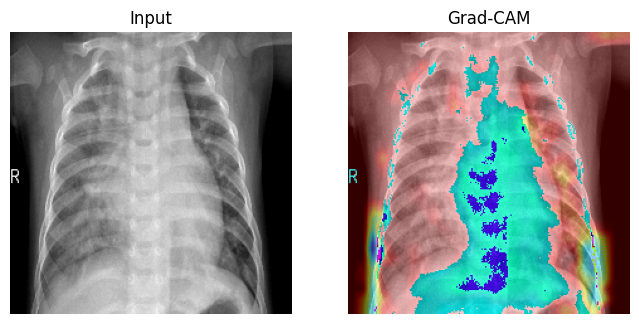

Image: /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person25_virus_59.jpeg


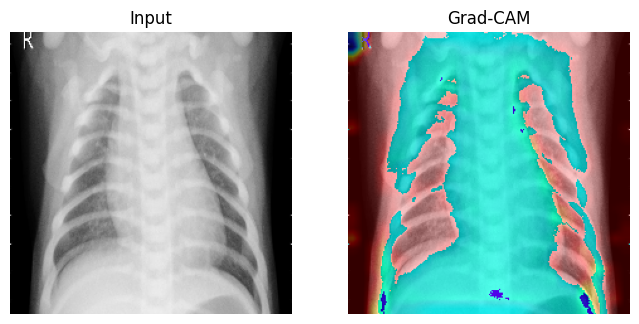

Image: /kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0123-0001.jpeg


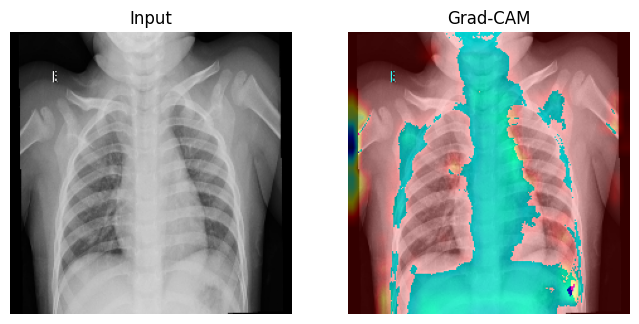

In [52]:
# === Cell 15: Grad-CAM visualization utility ===
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # img_array: [1,H,W,3] float32
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = 0
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.matmul(conv_outputs, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def show_gradcam_on_path(img_path, model, last_conv_layer_name=None):
    img = cv2.imread(img_path)[..., ::-1]
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype(np.float32)/255.0
    input_arr = np.expand_dims(img_resized, axis=0)
    # find last conv if not provided
    if last_conv_layer_name is None:
        last_conv_layer_name = None
        for layer in model.layers[::-1]:
            if isinstance(layer, layers.Conv2D):
                last_conv_layer_name = layer.name
                break
    heatmap = make_gradcam_heatmap(input_arr, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap * 0.4 + (img_resized*255)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img_resized); plt.title("Input"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(np.uint8(superimposed)); plt.title("Grad-CAM"); plt.axis('off')
    plt.show()

# Example Grad-CAM on a few test images
sample_paths = test_df.sample(3, random_state=SEED)['path'].values
for p in sample_paths:
    print("Image:", p)
    show_gradcam_on_path(p, model)

Testing fixed Grad-CAM implementation...
Available convolutional layers: ['conv2d_12', 'depthwise_conv2d_5', 'conv2d_13', 'depthwise_conv2d_6', 'conv2d_14', 'conv2d_15', 'depthwise_conv2d_7', 'conv2d_16', 'conv2d_17', 'conv2d_18']


The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_75']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))


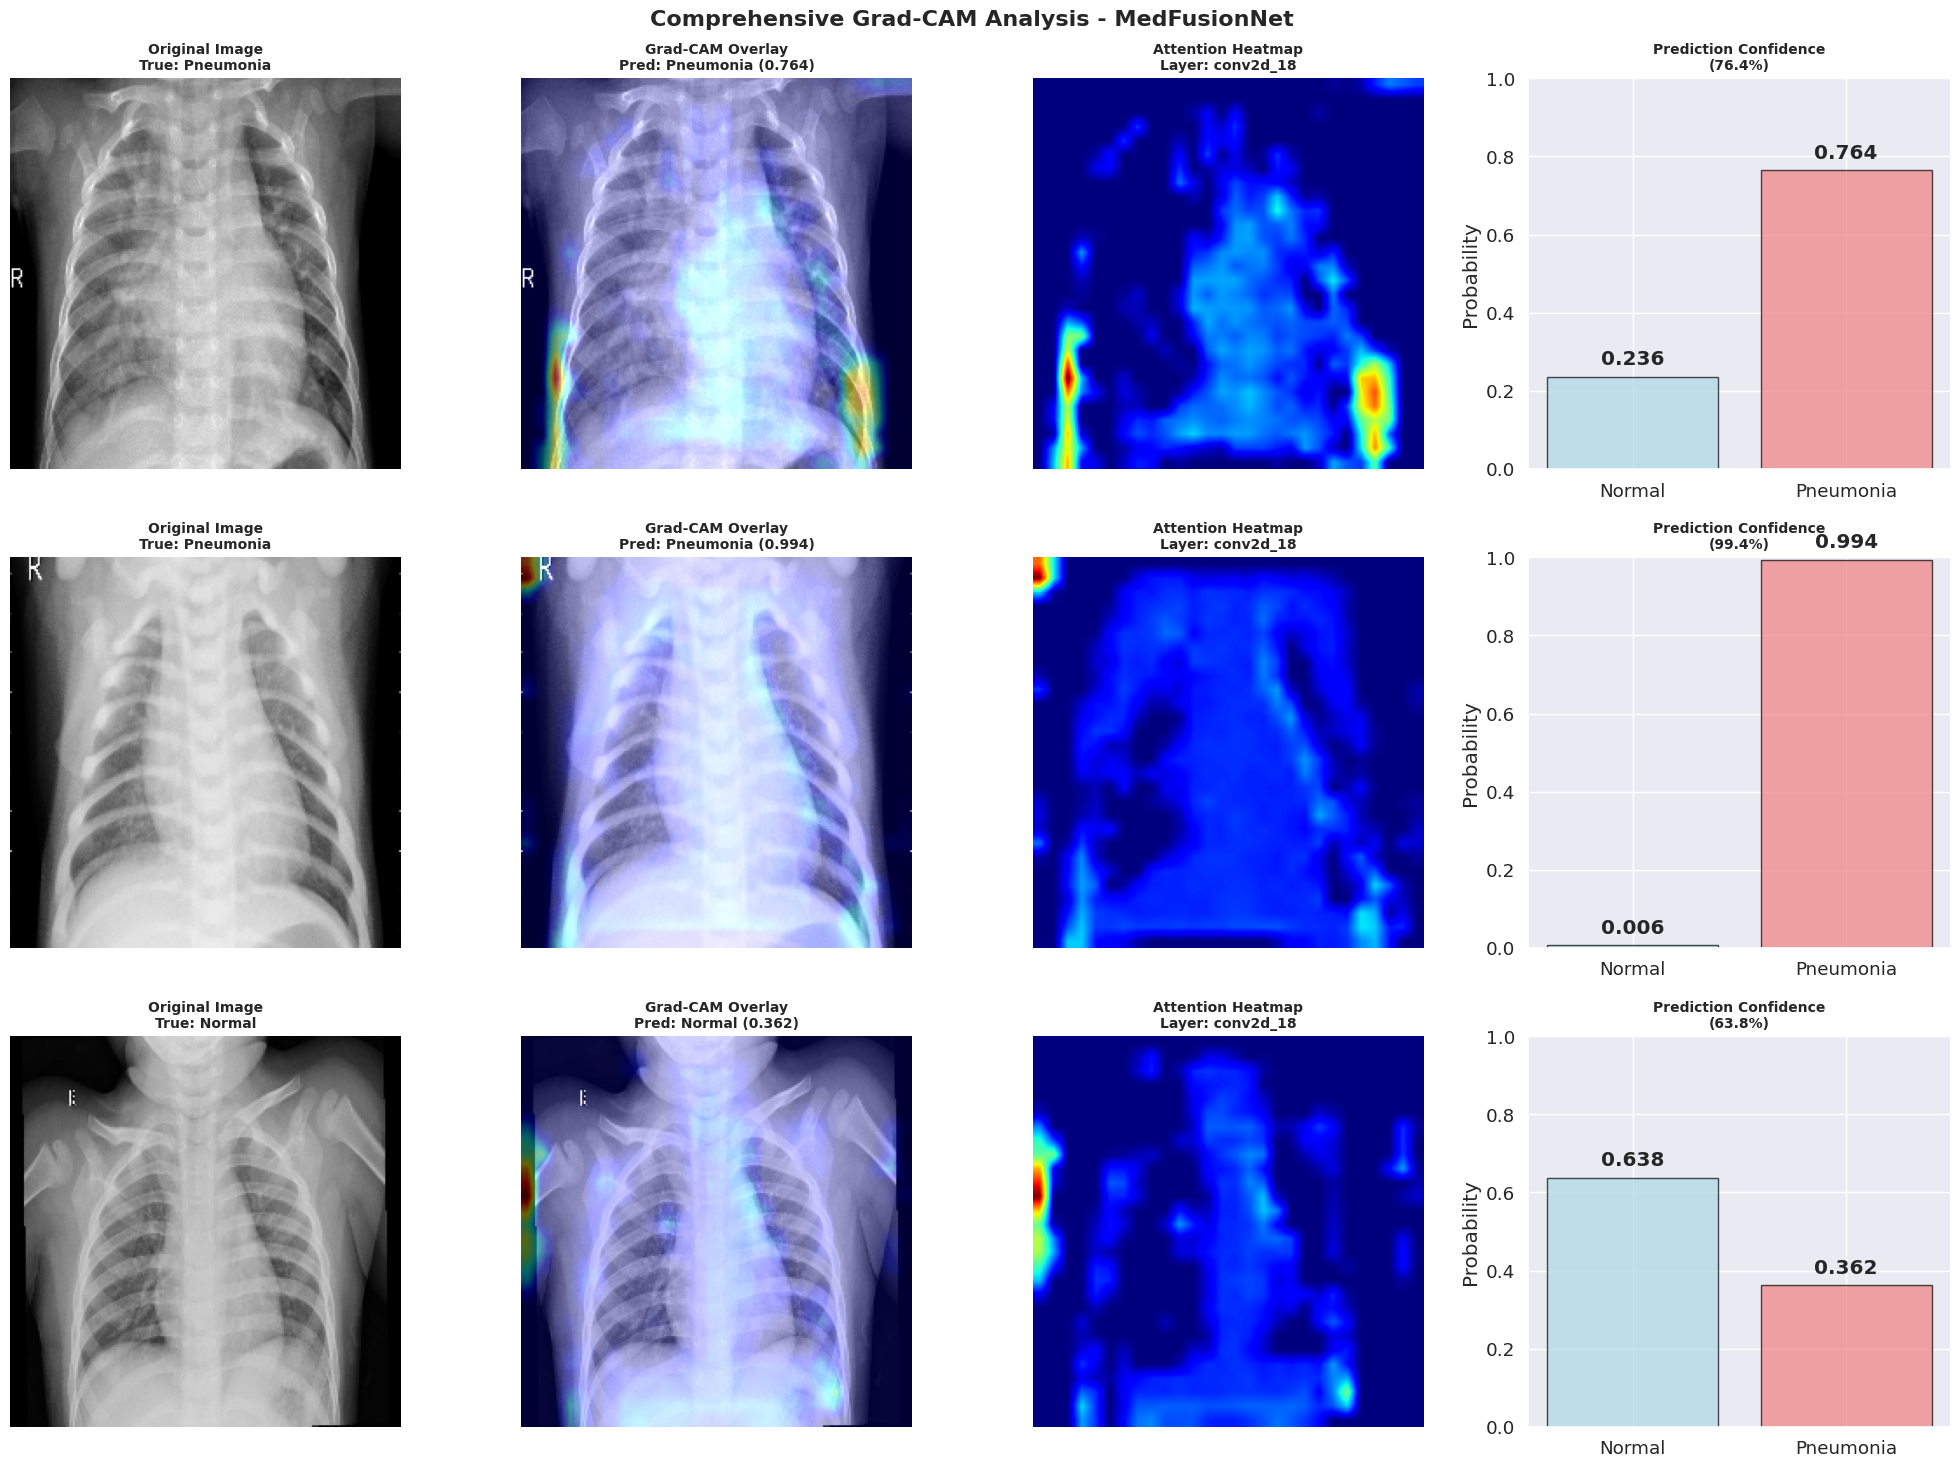

In [78]:
# === Fixed Grad-CAM Implementation ===
def make_gradcam_heatmap_fixed(img_array, model, last_conv_layer_name=None, pred_index=None):
    """
    Fixed Grad-CAM implementation with automatic layer detection
    """
    # Automatically find the last convolutional layer if not specified
    if last_conv_layer_name is None:
        for layer in model.layers[::-1]:
            if isinstance(layer, (layers.Conv2D, layers.DepthwiseConv2D)):
                last_conv_layer_name = layer.name
                print(f"Auto-selected layer: {last_conv_layer_name}")
                break
    
    # Create gradient model
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = 0
        loss = predictions[:, pred_index]
    
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the feature maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), last_conv_layer_name

def plot_comprehensive_gradcam_fixed(model, test_df, num_samples=4):
    """
    Fixed comprehensive Grad-CAM visualization
    """
    sample_df = test_df.sample(num_samples, random_state=SEED)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    # Get available convolutional layers for debugging
    conv_layers = [layer.name for layer in model.layers 
                  if isinstance(layer, (layers.Conv2D, layers.DepthwiseConv2D))]
    print(f"Available convolutional layers: {conv_layers}")
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        img_path = row['path']
        true_label = row['label']
        
        # Load and preprocess image
        img = cv2.imread(img_path)[..., ::-1]  # BGR to RGB
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img_normalized = img_resized.astype(np.float32) / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)
        
        # Get prediction
        pred_prob = model.predict(img_batch, verbose=0)[0][0]
        pred_label = 'pneumonia' if pred_prob > 0.5 else 'normal'
        confidence = max(pred_prob, 1-pred_prob)
        
        # Generate Grad-CAM heatmap
        try:
            # Try different potential layers
            target_layers = ['conv2d_18', 'conv2d_17', 'conv2d_16', 'depthwise_conv2d_7']
            heatmap = None
            used_layer = None
            
            for layer_name in target_layers:
                try:
                    heatmap, used_layer = make_gradcam_heatmap_fixed(
                        img_batch, model, layer_name
                    )
                    break
                except Exception as e:
                    continue
            
            if heatmap is None:
                # Auto-detect layer
                heatmap, used_layer = make_gradcam_heatmap_fixed(img_batch, model)
                
        except Exception as e:
            print(f"Grad-CAM failed for image {idx}: {e}")
            # Create a dummy heatmap
            heatmap = np.zeros((IMG_SIZE // 4, IMG_SIZE // 4))
            used_layer = "auto_detected"
        
        # Resize heatmap to match image size
        heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
        
        # Apply colormap
        heatmap_colored = cv2.applyColorMap(
            np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Create superimposed image
        superimposed = heatmap_colored * 0.4 + img_resized
        superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
        
        # Plot 1: Original image
        axes[idx, 0].imshow(img_resized)
        axes[idx, 0].set_title(
            f'Original Image\nTrue: {true_label.title()}',
            fontweight='bold', fontsize=10
        )
        axes[idx, 0].axis('off')
        
        # Plot 2: Heatmap overlay
        axes[idx, 1].imshow(superimposed)
        axes[idx, 1].set_title(
            f'Grad-CAM Overlay\nPred: {pred_label.title()} ({pred_prob:.3f})',
            fontweight='bold', fontsize=10
        )
        axes[idx, 1].axis('off')
        
        # Plot 3: Heatmap only
        axes[idx, 2].imshow(heatmap_resized, cmap='jet')
        axes[idx, 2].set_title(
            f'Attention Heatmap\nLayer: {used_layer}',
            fontweight='bold', fontsize=10
        )
        axes[idx, 2].axis('off')
        
        # Plot 4: Probability visualization
        colors = ['lightblue', 'lightcoral']
        labels = ['Normal', 'Pneumonia']
        probs = [1-pred_prob, pred_prob]
        
        bars = axes[idx, 3].bar(labels, probs, color=colors, alpha=0.7, edgecolor='black')
        axes[idx, 3].set_ylim(0, 1)
        axes[idx, 3].set_title(
            f'Prediction Confidence\n({confidence:.1%})',
            fontweight='bold', fontsize=10
        )
        axes[idx, 3].set_ylabel('Probability')
        
        # Add probability values on bars
        for bar, prob in zip(bars, probs):
            axes[idx, 3].text(
                bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{prob:.3f}', ha='center', va='bottom', fontweight='bold'
            )
    
    plt.suptitle(
        'Comprehensive Grad-CAM Analysis - MedFusionNet',
        fontsize=16, fontweight='bold', y=0.98
    )
    plt.tight_layout()
    plt.show()

# Test the fixed Grad-CAM
print("Testing fixed Grad-CAM implementation...")
plot_comprehensive_gradcam_fixed(model, test_df, num_samples=3)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


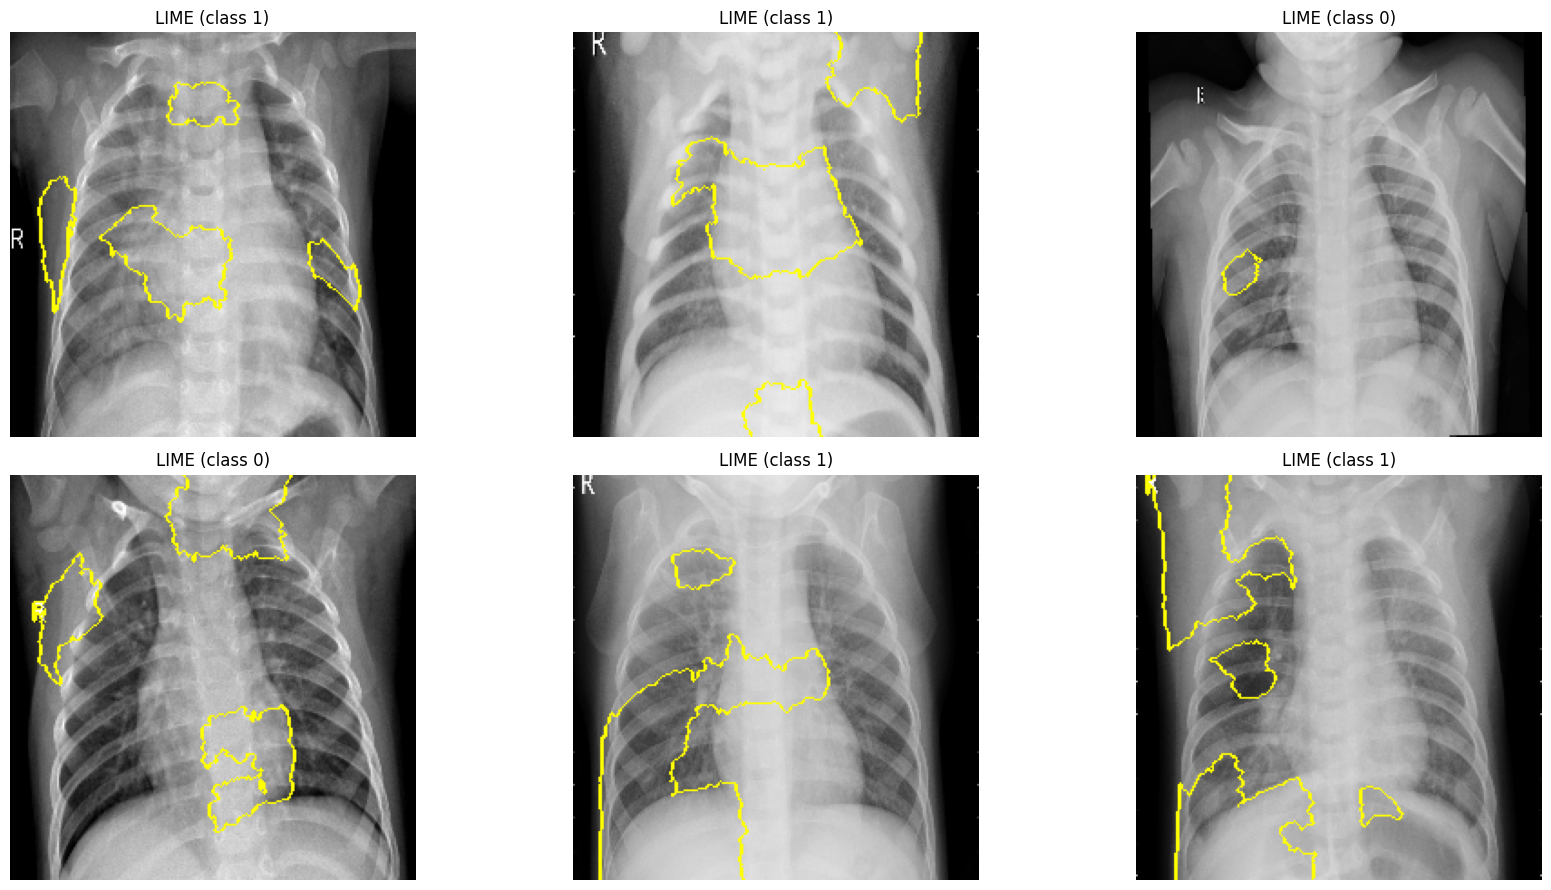

In [65]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ------------------------------
# Function to wrap your model for LIME
# ------------------------------
def lime_predict_proba(imgs):
    imgs_resized = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)).astype(np.float32)/255.0 for img in imgs])
    preds = model.predict(imgs_resized)
    return np.concatenate([1 - preds, preds], axis=1)

# ------------------------------
# Create LIME explainer
# ------------------------------
explainer_lime = lime_image.LimeImageExplainer()

# ------------------------------
# Pick 6 random test images
# ------------------------------
sample_paths = test_df.sample(6, random_state=42)['path'].values
sample_imgs = [cv2.imread(p)[..., ::-1] for p in sample_paths]  # BGR -> RGB

# ------------------------------
# Generate LIME explanations and plot
# ------------------------------
plt.figure(figsize=(18, 9))

for i, img in enumerate(sample_imgs):
    # Explain instance
    lime_exp = explainer_lime.explain_instance(
        cv2.resize(img, (IMG_SIZE, IMG_SIZE)),
        classifier_fn=lime_predict_proba,
        top_labels=2,
        hide_color=0,
        num_samples=200
    )
    
    # Get top predicted label
    top_label = lime_exp.top_labels[0]
    temp, mask = lime_exp.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    
    # Plot
    plt.subplot(2, 3, i+1)
    plt.imshow(mark_boundaries(temp/255.0, mask))
    plt.title(f"LIME (class {top_label})")
    plt.axis('off')

plt.tight_layout()
plt.show()
